In [1]:
!pip install seaborn
!pip install ta
!pip install statsmodels



  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=dade55bb75d8ffaf2556e65345d481c3c4be647a7375caa735c461ef69229262
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


### Lets import all necessary libraries for the analysis

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from ta.utils import dropna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from ta.volatility import BollingerBands 
import ta


### Load Dataset

In [3]:

import pandas as pd

# reading the database
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
data_test = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')
 
# printing the top 10 rows
display(data.head(10))
display(data_test.head(10))
data.shape
data_test.shape

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy
5,5,2015-07-06,51.374399,58.494017,590857400,Buy
6,6,2015-07-13,45.851376,60.269347,693570200,Buy
7,7,2015-07-20,45.200332,52.738477,326224700,Buy
8,8,2015-07-27,49.402806,56.363684,288132300,Buy
9,9,2015-08-03,47.101190,55.975242,294538600,Buy


,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400
5,5,2021-04-05,69.625390,252489500
6,6,2021-04-12,72.046746,178234600
7,7,2021-04-19,71.426418,194482300
8,8,2021-04-26,70.060497,235236100
9,9,2021-05-03,68.483296,195113500


(100, 4)

### There are 300 rows in training dataset and 100 rows in test dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Date      300 non-null    object 
 2   Open      300 non-null    float64
 3   Close     300 non-null    float64
 4   Volume    300 non-null    int64  
 5   Strategy  300 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.2+ KB


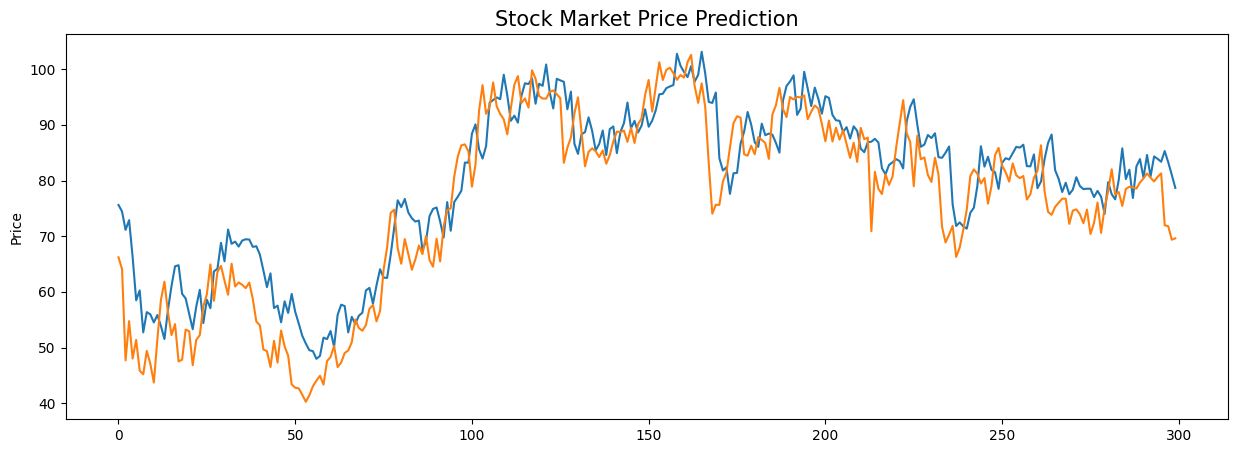

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 

plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.plot(data['Open'])

plt.title('Stock Market Price Prediction', fontsize=15)
plt.ylabel('Price')
plt.show()

### lets check if there are any duplicates in the dataset.

In [6]:
data.duplicated().sum()

0

### Lets check for the Null values in the dataset.

In [7]:
data.isnull().sum()


id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

In [8]:
data.sort_values('Date', inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,id,Open,Close,Volume,Strategy
Date,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold
2015-06-08,1,64.116235,74.443331,227974800,Hold
2015-06-15,2,47.701942,71.140831,250670900,Buy
2015-06-22,3,54.754816,72.881344,223614300,Hold
2015-06-29,4,48.031899,66.284718,406814900,Buy


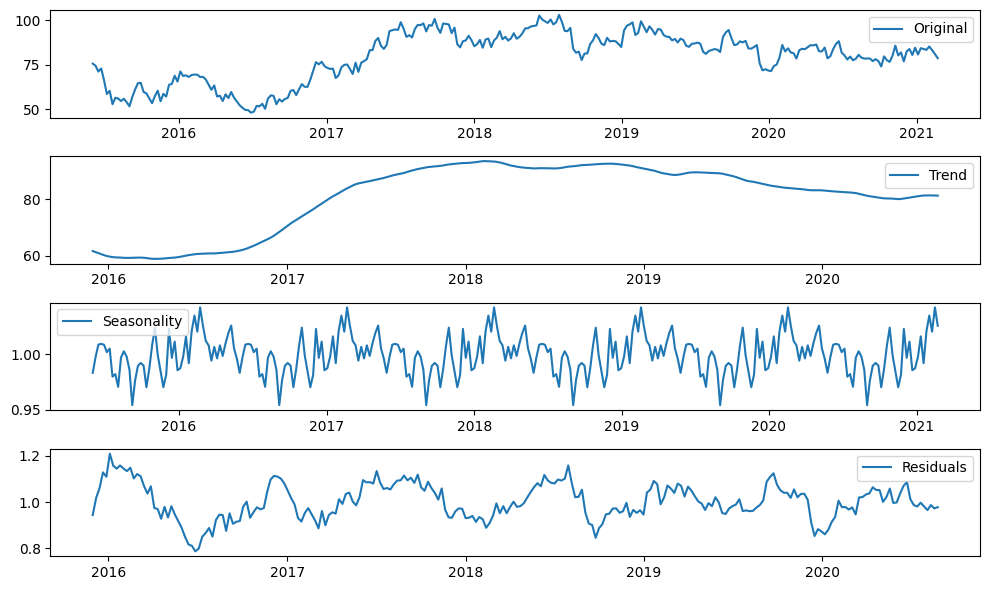

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='multiplicative')
#multiplicative decomposition is suitable if the magnitude of the seasonality changes with the trend, while additive works well if the magnitude remains constant.

trend = result.trend
seasonal = result.seasonal
residual = result.resid


plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(data['Close'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()



### Trend: The long-term progression of the time series exhibits an overall upward trajectory. However, a substantial spike is noticeable in 2017, followed by a gradual decline from 2019 onwards.

### Seasonality: Evident in the data is a distinct monthly pattern, highlighting a clear seasonal component.

### Residual: It's important to note that the residual component is not insignificant. Further analysis is needed to delve into this aspect of the data.

/tmp/ipykernel_18/2485470858.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)
/tmp/ipykernel_18/2485470858.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(data[col])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/2485470858.py:7: UserWarning: 

`distplot` is 

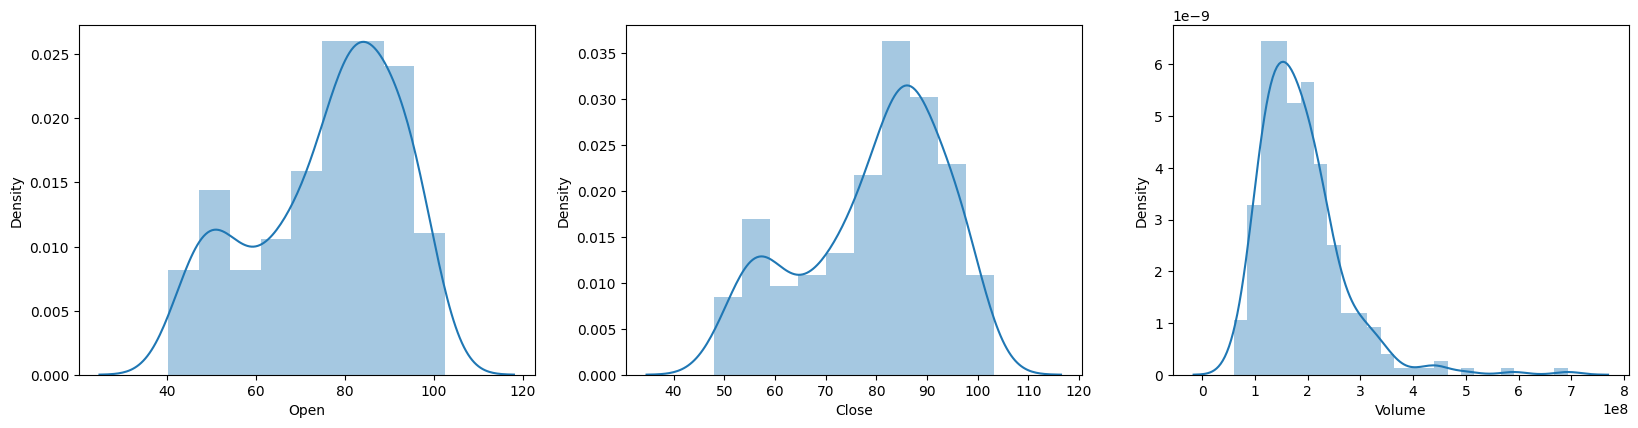

In [10]:
features = ['Open', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sb.distplot(data[col])
plt.show()


### visually explore the distribution of specific features ('Open,' 'Close,' and 'Volume') within the dataset. By creating subplots with histograms for each feature, it enables us to gain insights into the data's central tendencies and the spread of values. This is essential for understanding the statistical characteristics of these features, identifying potential outliers, and making informed decisions regarding data preprocessing or modeling. In essence, it provides a preliminary overview of the data's key attributes, aiding in data analysis and decision-making.

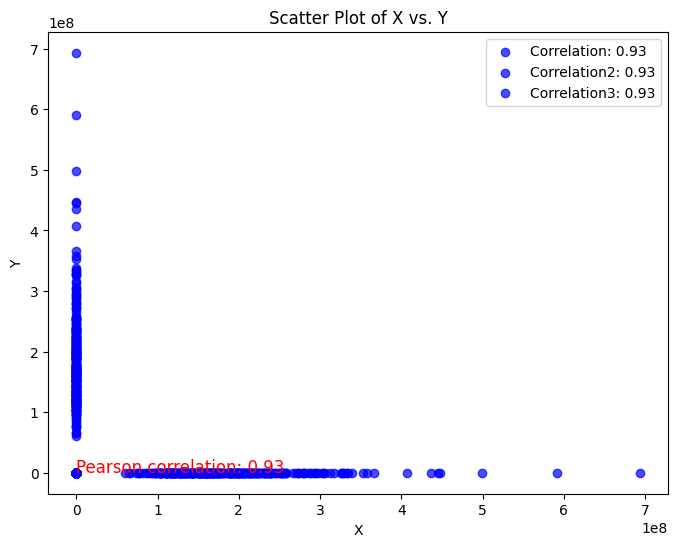

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset into a pandas DataFrame
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Extract the two variables you want to correlate
X = data["Open"]
Y = data["Close"]
Z = data["Volume"]
# Calculate the Pearson correlation coefficient
correlation = X.corr(Y)
correlation2 = Z.corr(Y)
correlation3 = X.corr(Z)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.7, color='b', label=f'Correlation: {correlation:.2f}')
plt.scatter(Z, Y, alpha=0.7, color='b', label=f'Correlation2: {correlation:.2f}')
plt.scatter(X, Z, alpha=0.7, color='b', label=f'Correlation3: {correlation:.2f}')
# Add labels and a title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of X vs. Y")

# Add a legend
plt.legend()

# Add text annotation for the correlation coefficient
plt.text(X.min(), Y.max(), f"Pearson correlation: {correlation:.2f}", fontsize=12, color='red')

# Show the plot
plt.show()


### we can see that Open and Close are linearly related.

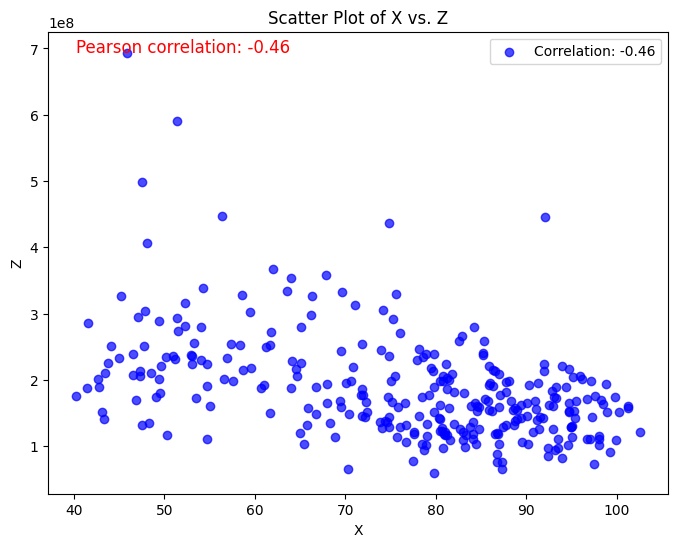

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset into a pandas DataFrame
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Extract the two variables you want to correlate
X = data["Open"]
Y = data["Close"]
Z = data["Volume"]
# Calculate the Pearson correlation coefficient
correlation = X.corr(Z)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X, Z, alpha=0.7, color='b', label=f'Correlation: {correlation:.2f}')

# Add labels and a title
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Scatter Plot of X vs. Z")

# Add a legend
plt.legend()

# Add text annotation for the correlation coefficient
plt.text(X.min(), Z.max(), f"Pearson correlation: {correlation:.2f}", fontsize=12, color='red')

# Show the plot
plt.show()

### we can see that Volume and Open are not related.

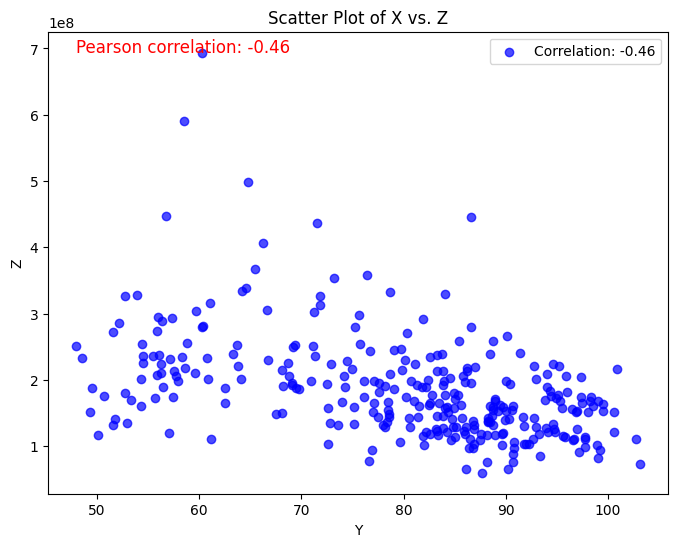

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset into a pandas DataFrame
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Extract the two variables you want to correlate
X = data["Open"]
Y = data["Close"]
Z = data["Volume"]
# Calculate the Pearson correlation coefficient
correlation = Y.corr(Z)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Y, Z, alpha=0.7, color='b', label=f'Correlation: {correlation:.2f}')

# Add labels and a title
plt.xlabel("Y")
plt.ylabel("Z")
plt.title("Scatter Plot of X vs. Z")

# Add a legend
plt.legend()

# Add text annotation for the correlation coefficient
plt.text(Y.min(), Z.max(), f"Pearson correlation: {correlation:.2f}", fontsize=12, color='red')

# Show the plot
plt.show()

we can see that Volume and Close are not related

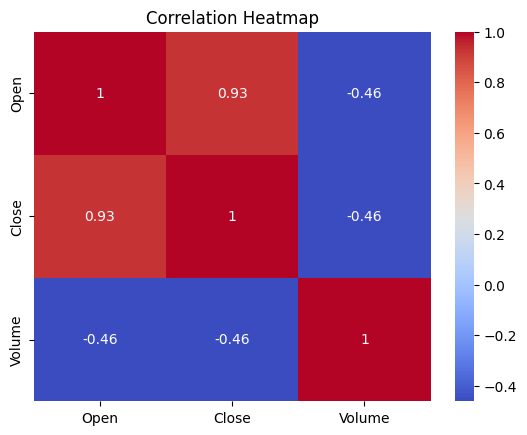

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset into a pandas DataFrame
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

numeric_features = data.drop(['id','Date','Strategy'], axis=1)
correlation_matrix = numeric_features.corr()
# Extract the two variables you want to correlate
# X = data["Open"]
# Y = data["Close"]
# Z = data["Volume"]


# correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


### we can see that open and close are highly correlated 


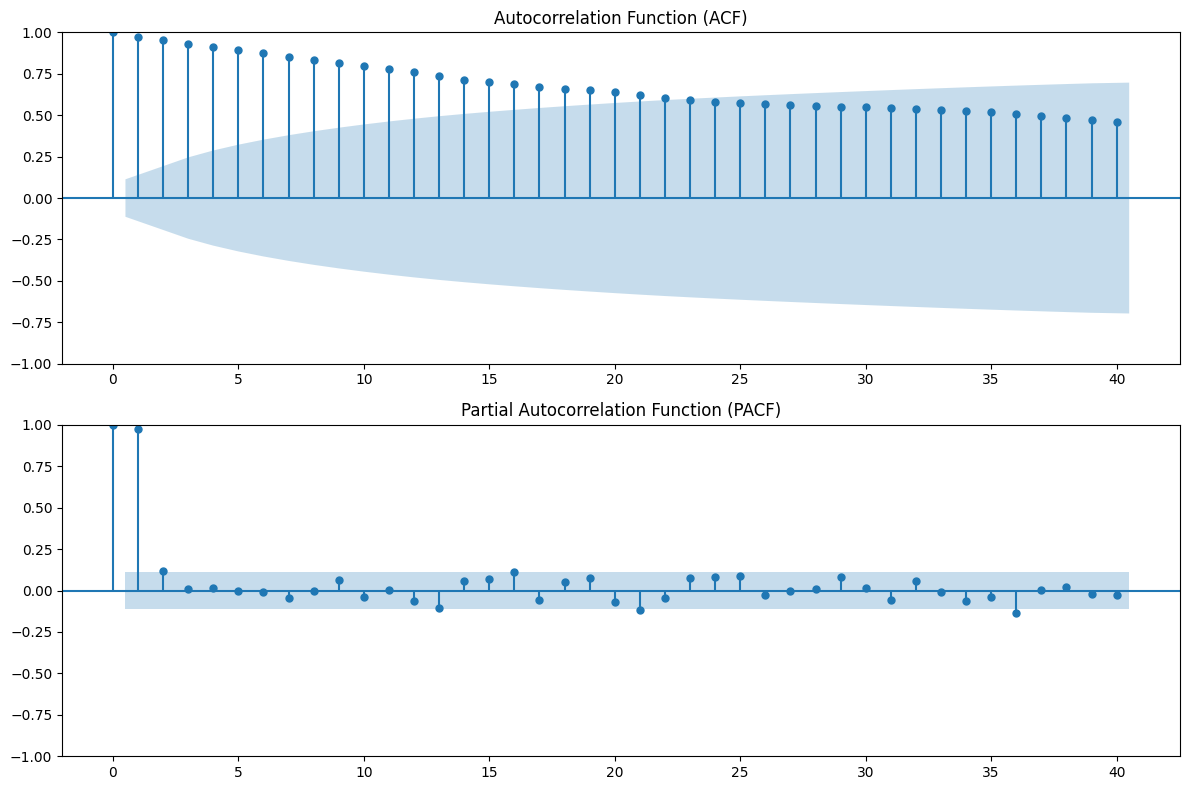

In [15]:
df = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
#Plotting ACF and PCF for the Close column before differncing
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'Close' is the name of your DataFrame column
close_series = df['Close']

# Create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
sm.graphics.tsa.plot_acf(close_series, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
sm.graphics.tsa.plot_pacf(close_series, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


### A gradually decreasing ACF plot indicates that there is a long-term dependency between data points, this often points to the presence of a trend. this proves that the data is non-stationary sharp cutoff suggests that there is a strong, direct relationship between the time series and its previous lags, but not with lags further back in time. so we do differencing of the series

In [16]:
#we perform ADF test to confirm the series is non-stationary
import statsmodels.api as sm

# Assuming 'Close,' 'Open,' and 'Volume' are the column names in your DataFrame
close_series = df['Close']
open_series = df['Open']
volume_series = df['Volume']

# Perform ADF test for 'Close'
adf_result_close = sm.tsa.adfuller(close_series)
print("ADF Test for 'Close':")
print(f'ADF Statistic: {adf_result_close[0]}')
print(f'p-value: {adf_result_close[1]}')
print(f'Critical Values: {adf_result_close[4]}')

# Perform ADF test for 'Open'
adf_result_open = sm.tsa.adfuller(open_series)
print("\nADF Test for 'Open':")
print(f'ADF Statistic: {adf_result_open[0]}')
print(f'p-value: {adf_result_open[1]}')
print(f'Critical Values: {adf_result_open[4]}')

# Perform ADF test for 'Volume'
adf_result_volume = sm.tsa.adfuller(volume_series)
print("\nADF Test for 'Volume':")
print(f'ADF Statistic: {adf_result_volume[0]}')
print(f'p-value: {adf_result_volume[1]}')
print(f'Critical Values: {adf_result_volume[4]}')


ADF Test for 'Close':
ADF Statistic: -1.8080055426222836
p-value: 0.37649446979222034
Critical Values: {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}

ADF Test for 'Open':
ADF Statistic: -1.904219816681667
p-value: 0.33007858725055095
Critical Values: {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}

ADF Test for 'Volume':
ADF Statistic: -3.327071678181228
p-value: 0.013710894607624674
Critical Values: {'1%': -3.4531816058796143, '5%': -2.871593390724642, '10%': -2.5721268156511536}


### we perform ADF test to confirm the series is non-stationary
### From the output we cn say that Close an Open are  non-stationary because p value>0.05 this indicates that the  null hypothesis is accepted and the series is non-stationary  the p value for volume is <0.05 and it is stationary

ADF Test for 'Close_diff':
ADF Statistic: -19.615947588858155
p-value: 0.0
Critical Values: {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}


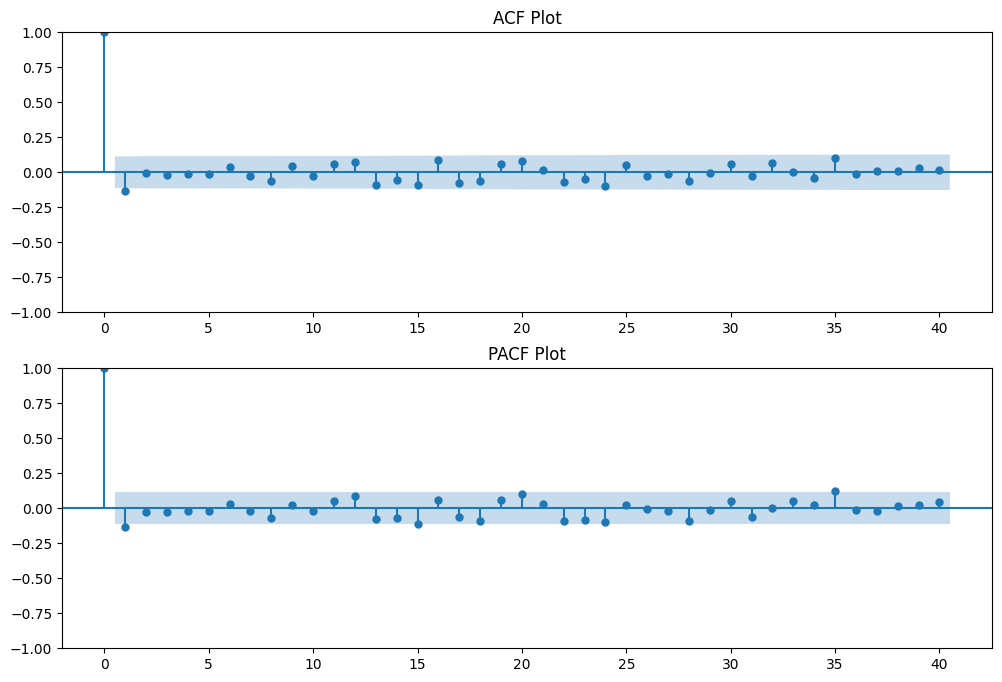

In [17]:
#now we do differencing  for Close to convdert it to staionary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming you have a DataFrame 'df' with columns 'Date', 'Close', 'Open', and 'Volume'

# Step 1: Differencing
df['Close_diff'] = df['Close'] - df['Close'].shift(1)

# Step 2: ADF Test
adf_result = adfuller(df['Close_diff'].dropna(), autolag='AIC')
print("ADF Test for 'Close_diff':")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:", adf_result[4])

# Step 3: ACF and PACF Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df['Close_diff'].dropna(), lags=40, ax=ax1)
ax1.set_title('ACF Plot')

# PACF Plot
plot_pacf(df['Close_diff'].dropna(), lags=40, ax=ax2)
ax2.set_title('PACF Plot')

plt.show()

### After doing differencing  for CLose we get the p value as 0 ant the null hyphothesis is rejected the series is stationary and d value is 1 From the  ACF plot we get the q value  as 20 and p value 2  because of the sharp cut-off the graph 

ADF Test for 'Open_diff':
ADF Statistic: -11.911261600580385
p-value: 5.289980209954452e-22
Critical Values: {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}


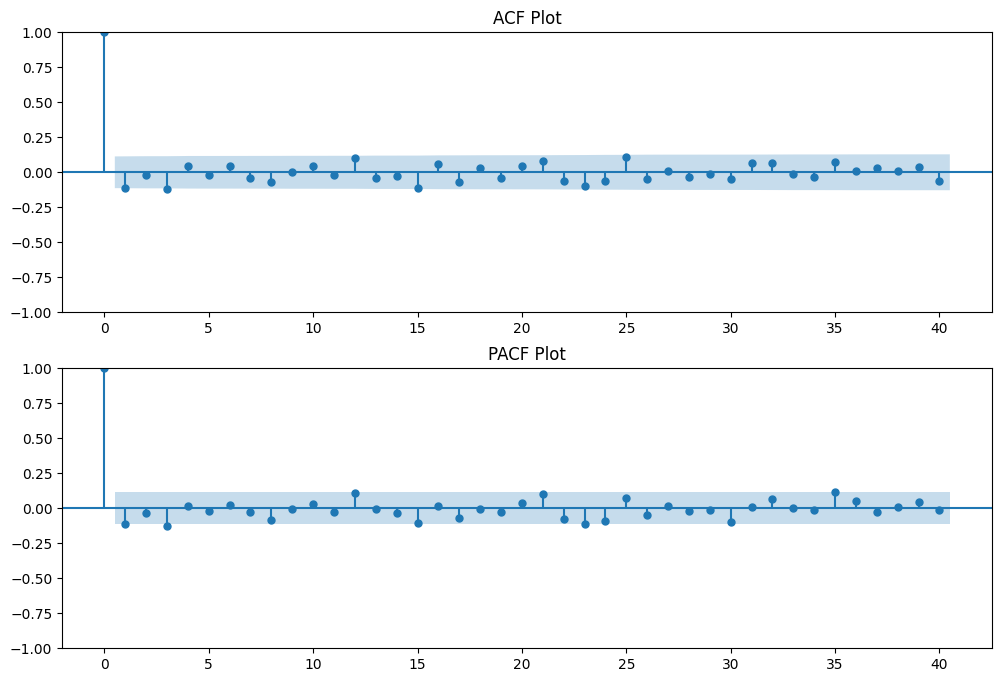

In [18]:
##now we do differencing  for Open Column to convert it to staionary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming you have a DataFrame 'df' with columns 'Date', 'Close', 'Open', and 'Volume'

# Step 1: Differencing
df['Open_diff'] = df['Open'] - df['Open'].shift(1)

# Step 2: ADF Test
adf_result = adfuller(df['Open_diff'].dropna(), autolag='AIC')
print("ADF Test for 'Open_diff':")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:", adf_result[4])

# Step 3: ACF and PACF Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df['Open_diff'].dropna(), lags=40, ax=ax1)
ax1.set_title('ACF Plot')

# PACF Plot
plot_pacf(df['Open_diff'].dropna(), lags=40, ax=ax2)
ax2.set_title('PACF Plot')

plt.show()

### After doing differencing  for open the series is stationary and d value is 1 From the  ACF plot we get the q  value  and p value  because of the sharp cut-off the graph

In [19]:
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

### Convert the 'Date' column to a datetime object

In [20]:

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

### Calculate technical indicators from ta

In [21]:
data = add_all_ta_features(data, 'Open', 'Open', 'Open', 'Open', 'Volume', fillna=True)

/opt/conda/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


### Define the train-validation split point (e.g., 80% for training)

In [22]:
split_point = int(len(data) * 0.8)
train, valid = data[:split_point], data[split_point:]

### Add lagged values of 'Open'

In [23]:
num_lags = 4  # Number of lagged values
for lag in range(1, num_lags + 1):
    train[f'Open_Lag_{lag}'] = train['Open'].shift(lag)
    valid[f'Open_Lag_{lag}'] = valid['Open'].shift(lag)

/tmp/ipykernel_18/1418031347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'Open_Lag_{lag}'] = train['Open'].shift(lag)
/tmp/ipykernel_18/1418031347.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[f'Open_Lag_{lag}'] = valid['Open'].shift(lag)
/tmp/ipykernel_18/1418031347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

### Calculate Open Price Momentum

In [24]:
n_days = 7  # Number of days for momentum calculation
train['Open_Momentum'] = train['Open'] - train['Open'].shift(n_days)
valid['Open_Momentum'] = valid['Open'] - valid['Open'].shift(n_days)

/tmp/ipykernel_18/781387838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Open_Momentum'] = train['Open'] - train['Open'].shift(n_days)
/tmp/ipykernel_18/781387838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Open_Momentum'] = valid['Open'] - valid['Open'].shift(n_days)


### Define the list of exogenous variables (including available features)

In [25]:
exog_features = ['Open', 'volatility_bbm', 'volatility_bbw', 'volatility_bbp', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'volume_obv', 'Open_Momentum']
exog_features += [f'Open_Lag_{lag}' for lag in range(1, num_lags + 1)]

exog_train = train[exog_features]
exog_valid = valid[exog_features]
y_train = train['Close']
y_valid = valid['Close']

mean_values = exog_train.mean()
exog_train = exog_train.fillna(mean_values)
exog_valid = exog_valid.fillna(mean_values)

# Correlation Analysis On Features

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


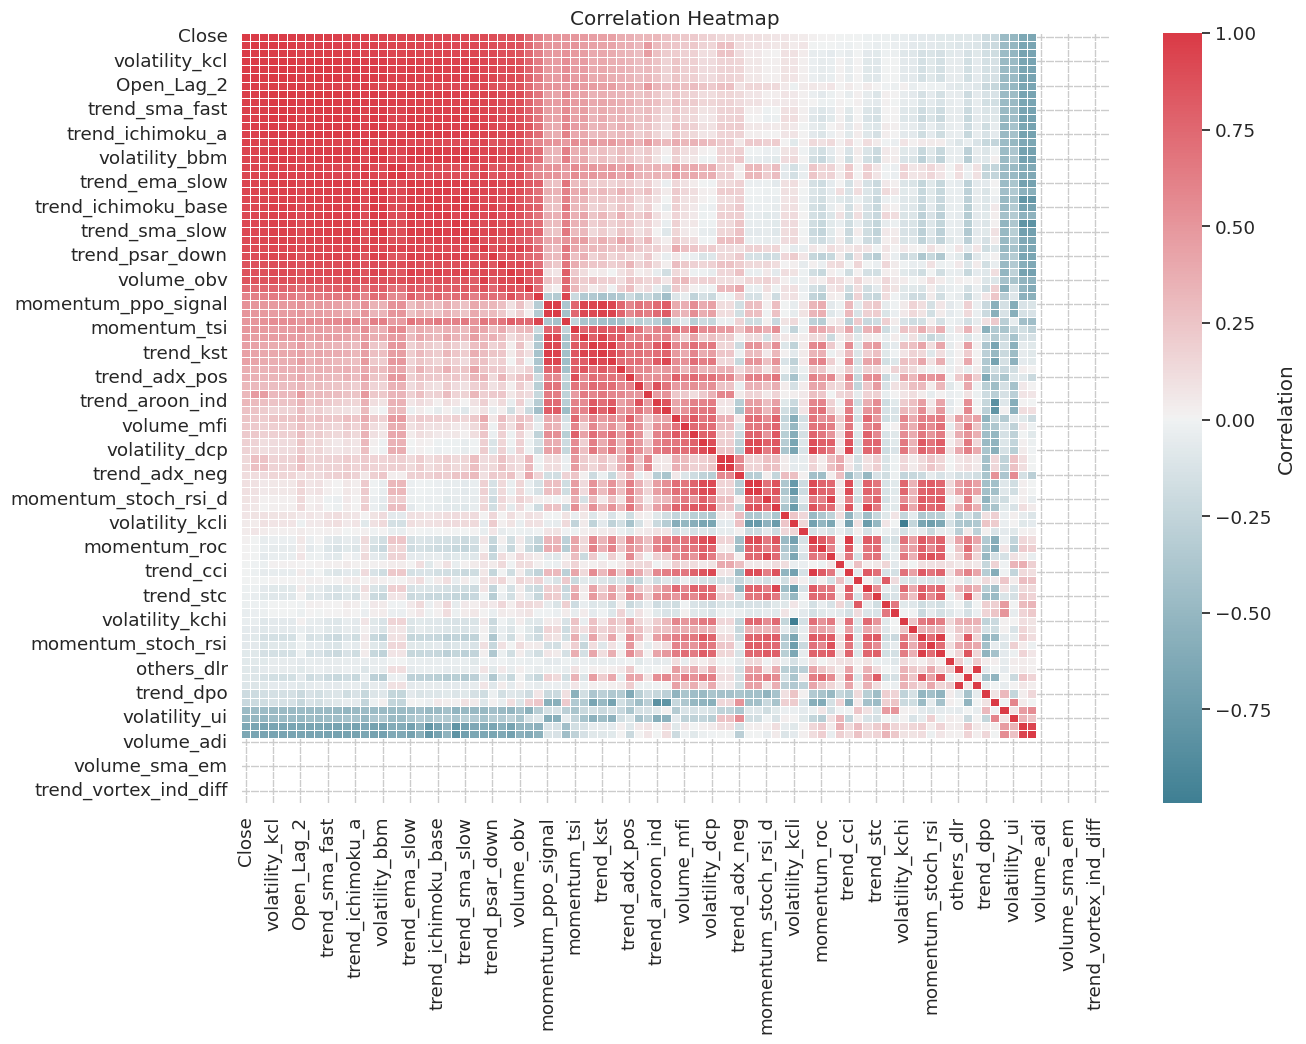

In [26]:


# Select only numeric columns in the training dataset
numeric_columns = train.select_dtypes(include=['number'])

# Calculate correlations between numeric features and the 'Close' variable
correlations = numeric_columns.corrwith(train['Close'])

# Sort the correlations in descending order
correlations = correlations.sort_values(ascending=False)

# Create a visually appealing heatmap without numeric values
plt.figure(figsize=(14, 10))  # Increase the figsize for a larger heatmap
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap without annotations
heatmap = sns.heatmap(
    numeric_columns[correlations.index].corr(),
    annot=False,  # Do not display numeric values
    cmap=cmap,
    cbar=True,
    cbar_kws={'label': 'Correlation'},
    linewidths=0.5,
)

plt.title("Correlation Heatmap")
plt.show()


**Strong Positive Correlations**

'Open_Lag_3,' 'Open_Lag_4,' 'volatility_kch,' and 'volatility_kcl' have very strong positive correlations with 'Close,' indicating a significant positive relationship.

**Strong Negative Correlations**

'volatility_ui' and 'volatility_dcw' exhibit strong negative correlations with 'Close,' suggesting a strong negative relationship.

**Moderate Correlations:**

Many features have moderate positive or negative correlations, indicating some degree of relationship with the closing price.

**Weak Correlations:**


Several features have weak or no correlations with 'Close,' suggesting limited influence on the closing price.

**Detailed Insights:**

* 'Open_Lag_3' and 'Open_Lag_4' show very strong positive correlations, suggesting that past opening prices, specifically 3 and 4 days ago, significantly influence the current closing price. This implies a time-series effect.

* 'volatility_ui' and 'volatility_dcw' have strong negative correlations, indicating that higher values of these volatility measures tend to push the closing price lower, reflecting increased market risk.

* Trend indicators like 'trend_ema_fast,' 'trend_sma_fast,' 'trend_ichimoku_conv,' and 'trend_ichimoku_a' have strong positive correlations, suggesting that changes in trends strongly affect the closing price.

* Some features have relatively weaker correlations, indicating less influence on the closing price.

# Close price prediction model (sarimax)

In [27]:
!pip install ta
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import numpy as np

# Load your dataset
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Convert the 'Date' column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate technical indicators
data = add_all_ta_features(data, 'Open', 'Open', 'Open', 'Open', 'Volume', fillna=True)

# Specify the SARIMAX order
p, d, q = 2, 1, 2
P, D, Q, S = 0, 0, 0, 0

# Create 'Open_Lag_3' by lagging the 'Open' feature by 3 time steps
data['Open_Lag_3'] = data['Open'].shift(3)

# Manually select the feature names you want to include
# Calculate additional features
data['Previous_High'] = data['Open'].shift(1).rolling(window=10).max()
data['Previous_Low'] = data['Open'].shift(1).rolling(window=10).min()
data['Previous_Close'] = data['Open'].shift(1)
data['MA_10'] = data['Open'].rolling(window=10).mean()

# Replace missing values with Backward Fill
data['Open_Lag_3'].fillna(method='bfill', inplace=True)
data['Previous_High'].fillna(method='bfill', inplace=True)
data['Previous_Low'].fillna(method='bfill', inplace=True)
data['Previous_Close'].fillna(method='bfill', inplace=True)
data['MA_10'].fillna(method='bfill', inplace=True)

# Define the train-validation split point (e.g., 80% for training)
split_point = int(len(data) * 0.7)
train, valid = data[:split_point], data[split_point:]

# Manually select the updated feature names
selected_feature_names = ['Open', 'Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Previous_High', 'Previous_Low', 'Previous_Close', 'MA_10']

# Create X-train and Y_train
X_train = train[selected_feature_names]
y_train = train['Close']

# Define the target variable
X_test = valid[selected_feature_names]
y_test = valid['Close']

# Build and fit the SARIMAX model using the updated selected features
arimax_model_selected = SARIMAX(endog=y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, S))
arimax_model_selected = arimax_model_selected.fit(disp=False)

# Forecast on the entire dataset using the updated selected features
forecast_sarimax = arimax_model_selected.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)

# Calculate SMAPE
smape = 100 * np.mean(np.abs(forecast_sarimax - y_test) / (np.abs(forecast_sarimax) + np.abs(y_test)))
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%')

/opt/conda/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/tmp/ipykernel_18/466922844.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Open_Lag_3'].fillna(method='bfill', inplace=True)
/tmp/ipykernel_18/466922844.py:35: FutureWarning: Series.fillna with 'method

Symmetric Mean Absolute Percentage Error (SMAPE): 0.94%


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# To create close price model (Multiple Linear Regression)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load your dataset
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Convert the 'Date' column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate technical indicators
data = add_all_ta_features(data, 'Open', 'Open', 'Open', 'Open', 'Volume', fillna=True)


data['Open_Lag_3'] = data['Open'].shift(3)
data['Previous_High'] = data['Open'].shift(1).rolling(window=10).max()
data['Previous_Low'] = data['Open'].shift(1).rolling(window=10).min()
data['Previous_Close'] = data['Open'].shift(1)
data['MA_10'] = data['Open'].rolling(window=10).mean()
# data['Close_Diff'] = data['Close'].diff()

# Replace missing values with Backward Fill
data['Open_Lag_3'].fillna(method='bfill', inplace=True)
data['Previous_High'].fillna(method='bfill', inplace=True)
data['Previous_Low'].fillna(method='bfill', inplace=True)
data['Previous_Close'].fillna(method='bfill', inplace=True)
data['MA_10'].fillna(method='bfill', inplace=True)
# data['Close_Diff'].fillna(method='bfill', inplace=True)

n = 5  # You can adjust the period as needed
data['Lowest_Low'] = data['Open'].rolling(window=n).min()
data['Highest_High'] = data['Open'].rolling(window=n).max()
data['%K'] = ((data['Open'] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low'])) * 100
# Calculate %D as a 3-day moving average of %K
data['%D'] = data['%K'].rolling(window=3).mean()
# Replace missing values with Backward Fill
data['%K'].fillna(method='bfill', inplace=True)
data['%D'].fillna(method='bfill', inplace=True)


y = data['Close']

# Manually select the updated feature names
# selected_feature_names = ['Open', 'Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Previous_High', 'Previous_Low', 'Previous_Close', 'MA_10']
selected_feature_names = ['Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'Previous_High', 'Previous_Close']
# selected_feature_names += ['%K', '%D']

# Create the feature matrix
X = data[selected_feature_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create and fit a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2): {r2:.2f}')
smape = 100 * np.mean(np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test)))
print(smape)

Mean Squared Error (MSE): 4.07
R-squared (R2): 0.98
1.0220292913560531


/opt/conda/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/tmp/ipykernel_18/1038271268.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Open_Lag_3'].fillna(method='bfill', inplace=True)
/tmp/ipykernel_18/1038271268.py:26: FutureWarning: Series.fillna with 'meth

## Creating heatmap

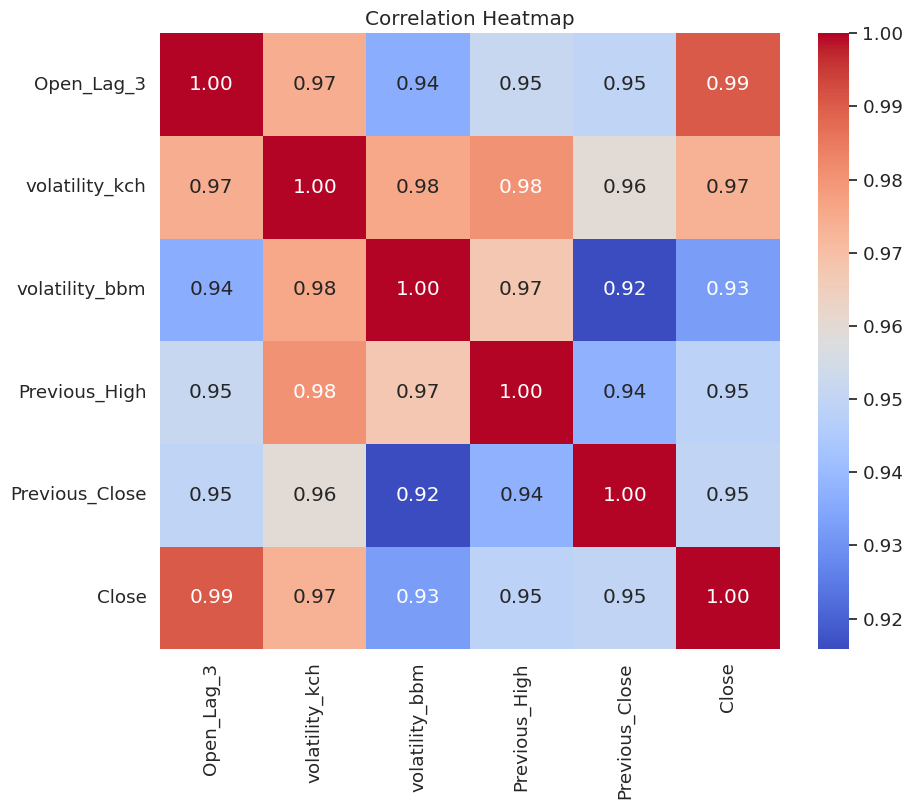

In [29]:
import seaborn as sns
# Calculate the correlation matrix
corr_features = selected_feature_names + ["Close"]
correlation_matrix = data[corr_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Combined MLR and SARIMAX for close price

/opt/conda/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/tmp/ipykernel_18/4187874473.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Open_Lag_3'].fillna(method='bfill', inplace=True)
/tmp/ipykernel_18/4187874473.py:34: FutureWarning: Series.fillna with 'meth

0.8559563766206167


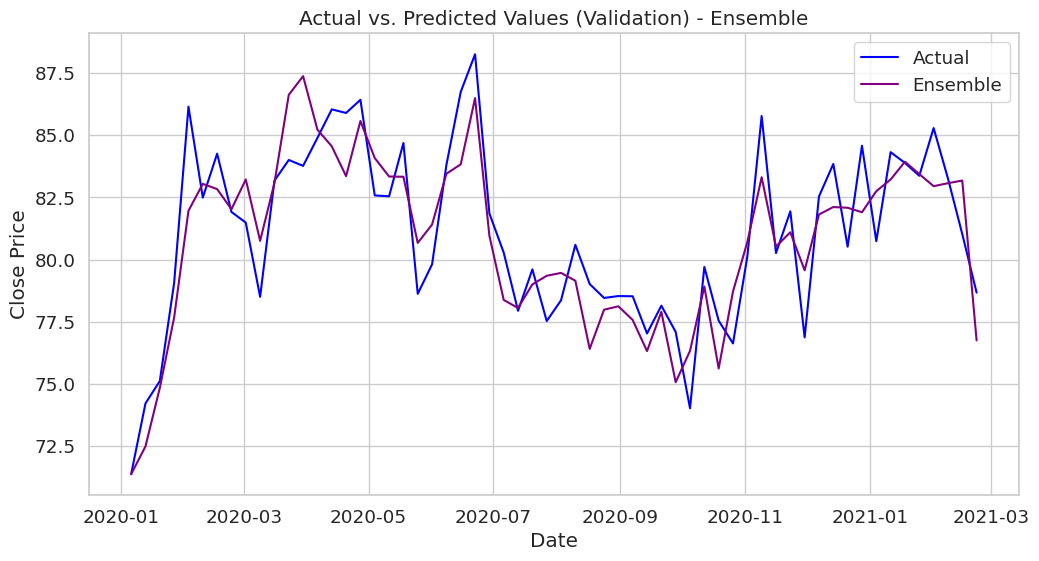

In [30]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import numpy as np

# Load your dataset
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Convert the 'Date' column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate technical indicators
data = add_all_ta_features(data, 'Open', 'Open', 'Open', 'Open', 'Volume', fillna=True)

# Specify the SARIMAX order
p, d, q = 1, 1, 2
P, D, Q, S = 0, 0, 0, 0

# Create 'Open_Lag_3' by lagging the 'Open' feature by 3 time steps
data['Open_Lag_3'] = data['Open'].shift(3)

# Manually select the feature names you want to include
# Calculate additional features
data['Previous_High'] = data['Open'].shift(1).rolling(window=10).max()
data['Previous_Low'] = data['Open'].shift(1).rolling(window=10).min()
data['Previous_Close'] = data['Open'].shift(1)
data['MA_10'] = data['Open'].rolling(window=10).mean()

# Replace missing values with Backward Fill
data['Open_Lag_3'].fillna(method='bfill', inplace=True)
data['Previous_High'].fillna(method='bfill', inplace=True)
data['Previous_Low'].fillna(method='bfill', inplace=True)
data['Previous_Close'].fillna(method='bfill', inplace=True)
data['MA_10'].fillna(method='bfill', inplace=True)

# Define the train-validation split point (e.g., 80% for training)
split_point = int(len(data) * 0.8)
train, valid = data[:split_point], data[split_point:]

# Manually select the updated feature names
selected_feature_names = ['Open', 'Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Previous_High', 'Previous_Low', 'Previous_Close', 'MA_10']
selected_feature_mlr = ['Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'Previous_High', 'Previous_Close']

# Create X-train and Y_train
X_train_sarimax = train[selected_feature_names]
X_train_mlr = train[selected_feature_mlr]
y_train = train['Close']

# Define the target variable
X_test_sarimax = valid[selected_feature_names]
X_test_mlr = valid[selected_feature_mlr]
y_test = valid['Close']

# Build and fit the SARIMAX model using the updated selected features
arimax_model_selected = SARIMAX(endog=y_train, exog=X_train_sarimax, order=(p, d, q), seasonal_order=(P, D, Q, S))
arimax_model_selected = arimax_model_selected.fit(disp=False)

# Forecast on the entire dataset using the updated selected features
forecast_sarimax = arimax_model_selected.predict(start=X_test_sarimax.index[0], end=X_test_sarimax.index[-1], exog=X_test_sarimax)

# Create and fit a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_mlr, y_train)

# Make predictions on the test data
lr_predictions = lr_model.predict(X_test_mlr)

combined_predictions = (0.5*forecast_sarimax + 0.5*lr_predictions)

smape = 100 * np.mean(np.abs(combined_predictions - y_test) / (np.abs(combined_predictions) + np.abs(y_test)))
print(smape)

# Visualize Actual vs. Predicted values for the validation set for the ensemble
plt.figure(figsize=(12, 6))
plt.plot(valid.index, valid['Close'], label='Actual', color='blue')
plt.plot(valid.index, combined_predictions, label='Ensemble', color='purple')
plt.title('Actual vs. Predicted Values (Validation) - Ensemble')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

### For closed_data.csv (Combined MLR and SARIMAX)

In [31]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import numpy as np
from sklearn.linear_model import LinearRegression


# Load your dataset
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
data2 = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')

# Convert the 'Date' column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data2['Date'] = pd.to_datetime(data2['Date'])
data2.set_index('Date', inplace=True)

# Calculate technical indicators
data = add_all_ta_features(data, 'Open', 'Open', 'Open', 'Open', 'Volume', fillna=True)
data2 = add_all_ta_features(data2, 'Open', 'Open', 'Open', 'Open', 'Volume', fillna=True)

# Specify the SARIMAX order
p, d, q = 1, 1, 2
P, D, Q, S = 0, 0, 0, 0

# Create features
data['Open_Lag_3'] = data['Open'].shift(3)
data['Previous_High'] = data['Open'].shift(1).rolling(window=10).max()
data['Previous_Low'] = data['Open'].shift(1).rolling(window=10).min()
data['Previous_Close'] = data['Open'].shift(1)
data['MA_10'] = data['Open'].rolling(window=10).mean()

data2['Open_Lag_3'] = data2['Open'].shift(3)
data2['Previous_High'] = data2['Open'].shift(1).rolling(window=10).max()
data2['Previous_Low'] = data2['Open'].shift(1).rolling(window=10).min()
data2['Previous_Close'] = data2['Open'].shift(1)
data2['MA_10'] = data2['Open'].rolling(window=10).mean()

# Replace missing values with Backward Fill
data['Open_Lag_3'].fillna(method='bfill', inplace=True)
data['Previous_High'].fillna(method='bfill', inplace=True)
data['Previous_Low'].fillna(method='bfill', inplace=True)
data['Previous_Close'].fillna(method='bfill', inplace=True)
data['MA_10'].fillna(method='bfill', inplace=True)

data2['Open_Lag_3'].fillna(method='bfill', inplace=True)
data2['Previous_High'].fillna(method='bfill', inplace=True)
data2['Previous_Low'].fillna(method='bfill', inplace=True)
data2['Previous_Close'].fillna(method='bfill', inplace=True)
data2['MA_10'].fillna(method='bfill', inplace=True)

# Define the train-validation split point (e.g., 80% for training)
# split_point = int(len(data) * 0.8)
# train, valid = data[:split_point], data[split_point:]

# Manually select the updated feature names
selected_feature_names = ['Open', 'Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Previous_High', 'Previous_Low', 'Previous_Close', 'MA_10']
selected_feature_mlr = ['Open_Lag_3', 'volatility_kch', 'volatility_bbm', 'Previous_High', 'Previous_Close']

# Create X-train and Y_train
X_train_sarimax = data[selected_feature_names]
X_train_mlr = data[selected_feature_mlr]
y_train = data['Close']

# Define the target variable
X_test_sarimax = data2[selected_feature_names]
X_test_mlr = data2[selected_feature_mlr]

# Build and fit the SARIMAX model using the updated selected features
arimax_model_selected = SARIMAX(endog=y_train, exog=X_train_sarimax, order=(p, d, q), seasonal_order=(P, D, Q, S))
arimax_model_selected = arimax_model_selected.fit(disp=False)

# Forecast on the entire dataset using the updated selected features
forecast_sarimax = arimax_model_selected.predict(start=X_test_sarimax.index[0], end=X_test_sarimax.index[-1], exog=X_test_sarimax)

# Create and fit a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_mlr, y_train)

# Make predictions on the test data
lr_predictions = lr_model.predict(X_test_mlr)

combined_predictions = (0.2*forecast_sarimax + 0.8*lr_predictions)

# smape = 100 * np.mean(np.abs(combined_predictions - y_test) / (np.abs(combined_predictions) + np.abs(y_test)))
# print(smape)

# # Visualize Actual vs. Predicted values for the validation set for the ensemble
# plt.figure(figsize=(12, 6))
# plt.plot(valid.index, valid['Close'], label='Actual', color='blue')
# plt.plot(valid.index, combined_predictions, label='Ensemble', color='purple')
# plt.title('Actual vs. Predicted Values (Validation) - Ensemble')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid(True)

data2 = data2.assign(Close=combined_predictions)
data2 = data2[["id", "Open", "Volume", "Close"]]
data2.to_csv('close_data.csv')

/opt/conda/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/opt/conda/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/tmp/ipykernel_18/990851988.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

# Correlation Analysis on Features for Ensemble Model

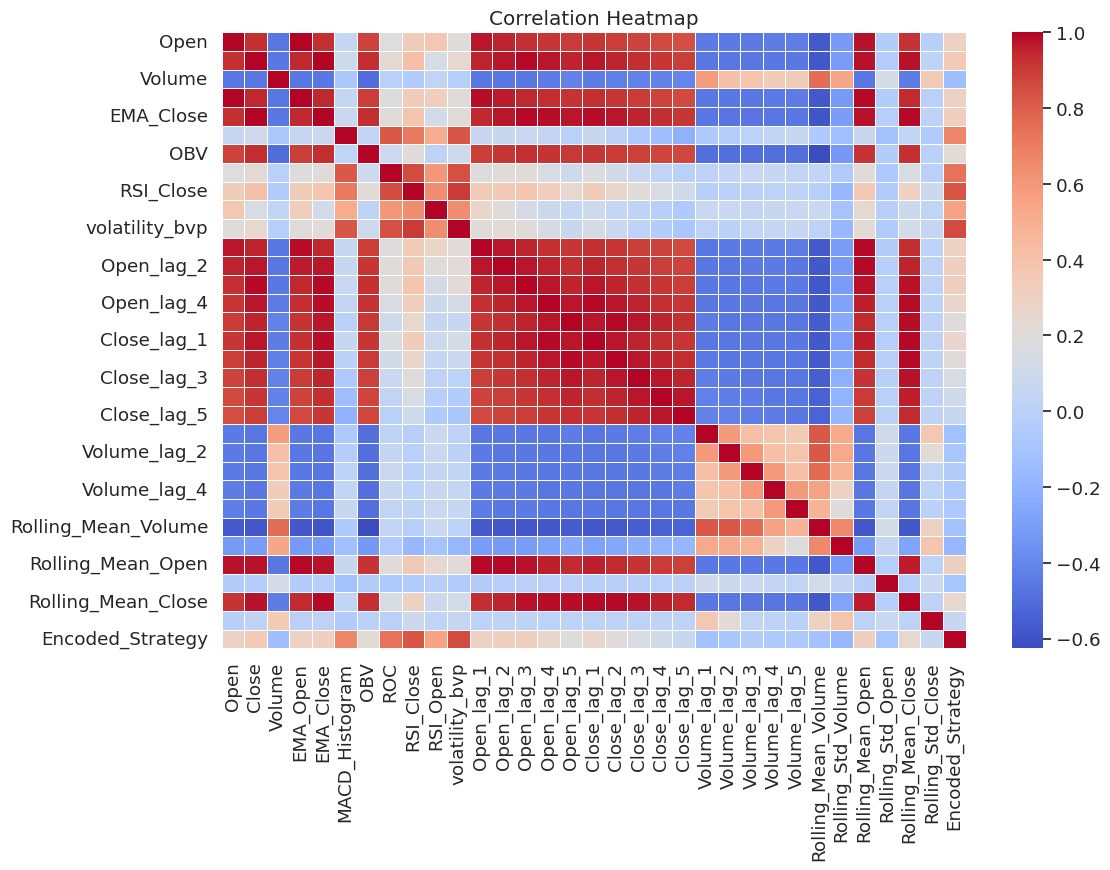

In [32]:

# Load the dataset from 'train.csv'
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Encode the 'Strategy' column using label encoding
label_encoder = LabelEncoder()
data['Encoded_Strategy'] = label_encoder.fit_transform(data['Strategy'])

# Create lag features for 'Open,' 'Close,' and 'Volume'
lag_periods = 5

for lag in range(1, lag_periods + 1):
    data[f'Open_lag_{lag}'] = data['Open'].shift(lag)
    data[f'Close_lag_{lag}'] = data['Close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['Volume'].shift(lag)

# Create rolling statistics features
rolling_window = 4
data['Rolling_Mean_Volume'] = data['Volume'].rolling(rolling_window).mean()
data['Rolling_Std_Volume'] = data['Volume'].rolling(rolling_window).std()
data['Rolling_Mean_Open'] = data['Open'].rolling(rolling_window).mean()
data['Rolling_Std_Open'] = data['Open'].rolling(rolling_window).std()
data['Rolling_Mean_Close'] = data['Close'].rolling(rolling_window).mean()
data['Rolling_Std_Close'] = data['Close'].rolling(rolling_window).std()

# Calculate the Exponential Moving Averages (EMA) for 'Open' and 'Close' columns
ema_period = 2
data['EMA_Open'] = ta.trend.ema_indicator(data['Open'], window=ema_period)
data['EMA_Close'] = ta.trend.ema_indicator(data['Close'], window=ema_period)

# Calculate the MACD and MACD Histogram
data['MACD'] = ta.trend.MACD(data['Close']).macd()
data['MACD_Histogram'] = ta.trend.MACD(data['Close']).macd_diff()

# Calculate the On-Balance Volume (OBV)
data['OBV'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])

# Calculate the Rate of Change (ROC)
roc_period = 13
data['ROC'] = ((data['Close'] - data['Close'].shift(roc_period)) / data['Close'].shift(roc_period)) * 100

# Calculate the Relative Strength Index (RSI) on 'Close'
rsi_period = 14
data['RSI_Close'] = ta.momentum.RSIIndicator(data['Close'], window=rsi_period).rsi()

# Calculate the Relative Strength Index (RSI) on 'Open'
data['RSI_Open'] = ta.momentum.RSIIndicator(data['Open'], window=rsi_period).rsi()

bollinger_window = 20  # Adjust the window size as needed
bollinger_bands = BollingerBands(close=data['Close'], window=bollinger_window)
data['volatility_bvp'] = bollinger_bands.bollinger_pband()

# Create a list of feature columns including 'volatility_bvp'
feature_columns = ['Open', 'Close', 'Volume', 'EMA_Open', 'EMA_Close', 'MACD_Histogram', 'OBV', 'ROC', 'RSI_Close', 'RSI_Open', 'volatility_bvp'] + [f'Open_lag_{lag}' for lag in range(1, lag_periods + 1)] + [f'Close_lag_{lag}' for lag in range(1, lag_periods + 1)] + [f'Volume_lag_{lag}' for lag in range(1, lag_periods + 1)] + ['Rolling_Mean_Volume', 'Rolling_Std_Volume', 'Rolling_Mean_Open', 'Rolling_Std_Open', 'Rolling_Mean_Close', 'Rolling_Std_Close']

# Calculate the correlations between features and the encoded 'Strategy'
correlations = data[feature_columns + ['Encoded_Strategy']].corr()

# Create a visually appealing heatmap with no numbers
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(correlations, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Insights and Inferences from Analysis

* 'Close' and 'Open' prices have moderate positive correlations with the encoded 'Strategy' (0.35 and 0.30, respectively), indicating their relevance in determining the strategy.

* 'Volume' shows a negative correlation with the encoded 'Strategy' (-0.13), suggesting that high trading volumes may not always correlate positively with the strategy.

* Exponential Moving Averages (EMAs) such as 'EMA_Open' and 'EMA_Close' exhibit moderate positive correlations (0.30 and 0.32, respectively), indicating their role in capturing short-term trends relevant to the strategy.

* The 'MACD_Histogram' has a strong positive correlation (0.66) with the encoded 'Strategy,' indicating its significance in strategy determination. A high positive MACD Histogram may signify a bullish strategy.

* The 'ROC' (Rate of Change) shows a very strong positive correlation (0.74) with the encoded 'Strategy,' suggesting that percentage price changes are crucial for strategy prediction.

* Relative Strength Index (RSI), particularly 'RSI_Close' (0.82) and 'RSI_Open' (0.56), displays strong positive correlations with the strategy, implying that high RSI values are associated with specific strategies.

* Lag features of 'Open' and 'Close' prices indicate that past price values are relevant, with positive correlations weakening as the lag period increases.

* 'Volume_lag' features have negative correlations with the strategy, with decreasing strength as the lag period increases, implying the importance of recent trading volumes.

* Rolling statistics, specifically 'Rolling_Mean_Open' (0.31) and 'Rolling_Mean_Close' (0.25), exhibit positive correlations, suggesting the relevance of rolling means of opening and closing prices. Conversely, 'Rolling_Std_Volume' has a negative correlation with the strategy.

* 'volatility_bvp' stands out with the highest positive correlation (0.86) with the encoded 'Strategy,' indicating its critical role in determining specific strategies. High volatility appears to be a strong indicator.

### Model For Strategy

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import ta

# Load the dataset from 'train.csv'
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

# Calculate RSI_Close feature
data['RSI_Close'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate ROC feature
data['ROC'] = ta.momentum.ROCIndicator(data['Close'], window=13).roc()

# Calculate MACD and MACD_histogram features
data['MACD'] = ta.trend.MACD(data['Close']).macd()
data['MACD_histogram'] = ta.trend.MACD(data['Close']).macd_diff()

# Calculate RSI_Open feature
data['RSI_Open'] = ta.momentum.RSIIndicator(data['Open'], window=14).rsi()

# Calculate EMA_Close feature using pandas
data['EMA_Close'] = data['Close'].ewm(span=10, adjust=False).mean()

# Calculate EMA_Open feature using pandas
data['EMA_open'] = data['Open'].ewm(span=10, adjust=False).mean()

# Calculate Rolling Mean Open feature
data['Rolling Mean Open'] = data['Open'].rolling(window=10).mean()

# Calculate Volatility_BVP feature
data['volatility_bvp'] = ta.volatility.BollingerBands(data['Close']).bollinger_pband()

# Calculate 'Open - Close' difference feature
data['Open_Close_Difference'] = data['Open'] - data['Close']

# Split the dataset into features (X) and the target variable (y) using the added features
X = data[['RSI_Close', 'ROC', 'MACD', 'MACD_histogram', 'RSI_Open', 'EMA_Close', 'Rolling Mean Open', 'EMA_open', 'Close', 'volatility_bvp', 'Open_Close_Difference']]
y = data['Strategy']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# Define the best hyperparameters for each classifier
best_rf_params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}
best_xgb_params = {'objective': 'multi:softprob', 'num_class': 3, 'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.5}

# Create individual classifiers with their best hyperparameters
rf_classifier = RandomForestClassifier(random_state=42, **best_rf_params)
xgb_classifier = xgb.XGBClassifier(random_state=42, **best_xgb_params)

# Define the weights for each model
weights = [0.50, 0.50]  # Adjust the weights for each classifier

# Create an ensemble of classifiers using majority voting with weights
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('xgb', xgb_classifier)
], voting='hard', weights=weights)

# Fit the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = ensemble_classifier.predict(X_test)

# Calculate the accuracy as a percentage
accuracy = accuracy_score(y_test, y_pred) * 100

# Print the accuracy
print(f"Accuracy with Ensemble Learning: {accuracy:.2f}%")

# Display the classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

Accuracy with Ensemble Learning: 85.00%

Classification Report:
               precision    recall  f1-score   support

         Buy       0.88      0.93      0.90        15
        Hold       0.81      0.89      0.85        28
        Sell       0.92      0.71      0.80        17

    accuracy                           0.85        60
   macro avg       0.87      0.84      0.85        60
weighted avg       0.86      0.85      0.85        60



### For Strategy column insubmission.csv (actual)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import ta
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Load the dataset from 'train.csv'
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
data2 = pd.read_csv('/kaggle/working/close_data.csv')

# Calculate some features
data['RSI_Close'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ROC'] = ta.momentum.ROCIndicator(data['Close'], window=13).roc()
data['MACD'] = ta.trend.MACD(data['Close']).macd()
data['MACD_histogram'] = ta.trend.MACD(data['Close']).macd_diff()
data['RSI_Open'] = ta.momentum.RSIIndicator(data['Open'], window=14).rsi()
data['EMA_Close'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA_open'] = data['Open'].ewm(span=10, adjust=False).mean()
data['Rolling Mean Open'] = data['Open'].rolling(window=10).mean()
data['volatility_bvp'] = ta.volatility.BollingerBands(data['Close']).bollinger_pband()
data['Open_Close_Difference'] = data['Open'] - data['Close']

data2['RSI_Close'] = ta.momentum.RSIIndicator(data2['Close'], window=14).rsi()
data2['ROC'] = ta.momentum.ROCIndicator(data2['Close'], window=13).roc()
data2['MACD'] = ta.trend.MACD(data2['Close']).macd()
data2['MACD_histogram'] = ta.trend.MACD(data2['Close']).macd_diff()
data2['RSI_Open'] = ta.momentum.RSIIndicator(data2['Open'], window=14).rsi()
data2['EMA_Close'] = data2['Close'].ewm(span=10, adjust=False).mean()
data2['EMA_open'] = data2['Open'].ewm(span=10, adjust=False).mean()
data2['Rolling Mean Open'] = data2['Open'].rolling(window=10).mean()
data2['volatility_bvp'] = ta.volatility.BollingerBands(data2['Close']).bollinger_pband()
data2['Open_Close_Difference'] = data2['Open'] - data2['Close']

# Split the dataset into features (X) and the target variable (y) using the added features
X_train = data[['RSI_Close', 'ROC', 'MACD', 'MACD_histogram', 'RSI_Open', 'EMA_Close', 'Rolling Mean Open', 'EMA_open', 'Close', 'volatility_bvp', 'Open_Close_Difference']]
X_test = data2[['RSI_Close', 'ROC', 'MACD', 'MACD_histogram', 'RSI_Open', 'EMA_Close', 'Rolling Mean Open', 'EMA_open', 'Close', 'volatility_bvp', 'Open_Close_Difference']]
y_train = data['Strategy']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

# Define the best hyperparameters for each classifier
best_rf_params = {'n_estimators': 300, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}
# best_xgb_params = {'objective': 'multi:softprob', 'num_class': 3, 'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.5}
# 
# lgbm_params = {'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0}

# Create individual classifiers with their best hyperparameters
rf_classifier = RandomForestClassifier(random_state=42, **best_rf_params)
gb_classifier =  GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3,max_leaf_nodes=2,warm_start =True, random_state=0)
# xgb_classifier = xgb.XGBClassifier(random_state=42, **best_xgb_params)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',break_ties=True, shrinking=False, C=10))
# lgbm = lgb.LGBMClassifier(**lgbm_params)

# Define the weights for each model
weights = [0.33, 0.33, 0.34]  # Adjust the weights for each classifier
# Create an ensemble of classifiers using majority voting with weights
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('clf', clf),
    ('gb', gb_classifier),
], voting='hard', weights=weights)

# Fit the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = ensemble_classifier.predict(X_test)

data2 = data2.assign(Strategy=y_pred)
data2 = data2[["id","Date", "Close", "Strategy"]]
data2.to_csv('submission.csv', index = False)